# Sentiment Analysis with Transformer Networks

The Transformer is a neural network architecture introduced in 2017 that is based solely on the so called Attention mechanism, which focuses on different parts on the input separately but simultaneously, instead of sequentially, like the neural network architectures we looked at previously. Allowing for much greater parallelization, this architecture is able to achieve state-of-the-art results in the field of natural language processing. In this notebook we will apply different Python implementations of Transformers to our IMDB movie review sentiment analysis task.

In [3]:
# Import standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [28]:
import sys

# Configure variables pointing to directories and stored files 
directory = './' # adjust to the directory where data is stored on your machine (if running the notebook locally)
if 'google.colab' in sys.modules:
    # Mount Google-Drive
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    directory += 'drive/MyDrive/notebooks/Git/adams/demos/nlp/'  # adjust to Google drive folder with the data if applicable   

sys.path.append(directory)

Mounted at /content/drive



When running this notebook in Google Colab, ensure that you run it with a GPU as hardware accelerator. To enable this:
- Navigate to Edit → Notebook Settings
- select GPU from the Hardware Accelerator drop-down

## Import IDMB movie review data

Let's first import the same data we have previously used for the sentiment analysis task.

In [30]:
# Load dataset with raw and preprocessed movie reviews
import pickle
#with open(directory + 'imdb_clean_full_v2.pkl' ,'rb') as path_name:
with open("./drive/MyDrive/notebooks/Git/adams/demos/nlp/" + 'imdb_clean_full_v2.pkl' ,'rb') as path_name:
    df = pickle.load(path_name)

In [31]:
# Binary-encode the target variable
df['sentiment'] = df['sentiment'].map({'positive' : 1, 'negative': 0})

In [32]:
# Draw the same random sample of n reviews to increase the speed of the following steps and ensure comparability
n = 5000
np.random.seed(111)
ix = np.random.randint(0, high=df.shape[0]-1, size=n)
df = df.loc[ix, :]
df.reset_index(drop=True, inplace=True)
df.head()

,review,sentiment,review_clean
0,Started watching this but didn't believe in an...,0,start watch believe character particular relat...
1,This totally UNfunny movie is so over the top ...,0,totally unfunny movie top pathetic unrealistic...
2,There is absolutely nothing to redeem this mov...,0,absolutely nothing redeem movie take sleazy st...
3,*****Warning: May contain SPOILERS********* My...,0,warn may contain spoiler huge problem movie to...
4,It's not surprising that the majority of highe...,1,surprising majority high rat vote submit femal...


Just like before we have a column 'review' with the raw movie reviews and a column 'review_clean' with the preprocessed movie reviews. Since we'll need it several times, we'll create a custom train-test split function.

In [33]:
# custom train-test split wrapper
from sklearn.model_selection import train_test_split

def IMDB_train_test_split(df, preprocessed=True, test_size=0.25, random_state=111, **kwargs):
    ''' Function to choose either raw or preprocessed data and perform a train-test split '''

    if preprocessed==True:
        column='review_clean'
    else:
        column='review'

    X_train, X_test, y_train, y_test = train_test_split(df[column],
                                                        df['sentiment'],
                                                        test_size=test_size,
                                                        random_state=random_state,
                                                        **kwargs)
    
    X_train, X_test = X_train.tolist(), X_test.tolist()
    y_train, y_test = y_train.tolist(), y_test.tolist()

    return X_train, X_test, y_train, y_test

In [34]:
# perform train-test split
X_train, X_test, y_train, y_test = IMDB_train_test_split(df)

## Huggingface pipelines

Transformer models are usually very large. With millions to tens of billions of parameters, training and deploying these models is a complicated undertaking. Furthermore, new models are being released more and more frequently and each one has its own implementation.

The French company Huggingface has set out to tackle that problem by developing a simple framwork to download and use fully pre-trained Transformer models for various use cases. Besides sentiment analysis those include image classification, speech recognition, text generation, translation and many more. A complete list can be found [here](https://huggingface.co/docs/transformers/main_classes/pipelines).

We will be using the sentiment analysis pipeline with the DistilBERT model, a distilled (reduced 40 % in size while maintaining 97 % of its performance) version of the BERT Transformer model, released by Google in 2018. Note that the pipeline automates several steps and obscures the fact that Transformers generally need a lot of code infrastructure and have many tunable parameters. We will show some of those steps in detail in the next part, where we finetune a Transformer model on our training data.

In [35]:
# install transformer library
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 26.6 MB/s 
     |████████████████████████████████| 6.6 MB 55.5 MB/s 
     |████████████████████████████████| 101 kB 10.8 MB/s 
     |████████████████████████████████| 596 kB 70.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [36]:
from transformers import pipeline

In [37]:
# Very simple, high-level way to use a specific transformer model for sentiment classification
classifier = pipeline('sentiment-analysis',
                      model='distilbert-base-uncased-finetuned-sst-2-english',
                      tokenizer='distilbert-base-uncased',
                      batch_size=64)

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [44]:
print(classifier('I love this book.'))

[{'label': 'POSITIVE', 'score': 0.9998767375946045}]


As you can see the pipeline outputs a classfication (POSITIVE or NEGATIVE) and a score that reflects its confidence. Try out a few other sentences and examine how the output changes. What is your impression of the overall accuracy of the model?


In order to evaluate model performace more comprehensively, we'll need to extract the score for each movie review and put them into a list. That's what the function below will do.

Note that even though the model is already trained and we only generate predictions with it, the code might still take a couple minutes to run, since the huggingface pipelines are not very well optimized for GPU usage (as opposed to the regular huggingface models, which we will look at next). [Link](https://github.com/huggingface/transformers/issues/14125)

In [45]:
def pipeline_classify(data):
    ''' Function to run the sentiment analysis pipeline on each row of a dataset
    and extract the scores. '''

    predictions = []

    for row in data:
          classification = classifier(row, truncation=True)[0]
          if classification['label'] == 'POSITIVE':
              predictions.append(classification['score'])
          else:
              predictions.append(1-classification['score'])
              
    return predictions

In [46]:
predictions = pipeline_classify(X_test)

Let's now take a look how well the model has performed. Since we'll need to evaluate several models we define a function for assessing our predictions and plotting the ROC curve.

In [47]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

def assess_sentiment_classifier(ytest, yhat, cutoff=0.5, plot_roc=True):
    ''' Function to assess a classification model in terms of the AUC
    and classification accuracy. '''

    # Calculate discrete class predictions
    yhat_discrete = np.where(pd.DataFrame(yhat)>cutoff, 1, 0)
    # Calculate classification accuracy and AUC
    acc = accuracy_score(ytest, yhat_discrete)
    auc = roc_auc_score(ytest, yhat)
    # Confusion matrix 
    cmat = confusion_matrix(ytest, yhat_discrete)
    # ROC analysis
    if plot_roc==True:
        fpr, tpr, _ = roc_curve(ytest, yhat)
        plt.plot(fpr,tpr, label="AUC={:.4}".format(auc));
        plt.plot([0, 1], [0, 1], "r--")
        plt.ylabel('True positive rate')    
        plt.xlabel('False positive rate')    
        plt.legend(loc='lower right')
        plt.show();
    
    print("NN test set performance:\tAUC={:.4f}\tAccuracy={:.4f}".format(auc, acc))
    print('Confusion matrix:')
    print(cmat)

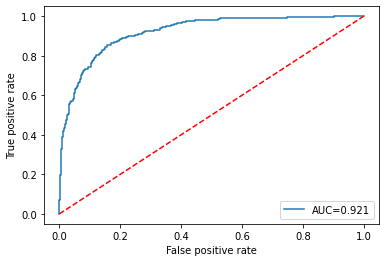

NN test set performance:	AUC=0.9210	Accuracy=0.8184
Confusion matrix:
[[585  47]
 [180 438]]


In [48]:
assess_sentiment_classifier(y_test, predictions)

A solid performance for a model that hasn't previously seen our movie reviews at all. Recall that a common practice in NLP transfer learning is to start from a pretrained model, as we did above, and to then finetune it using your target corpus. Our target corpus are the IMDB reviews. So let's see how much we can improve on the above result by finetuning our sentiment classifier using our  training data set. Just to reiterate, since a moving on to a slightly more advanced setting, compared to the *zero-shot* setting above (i.e., no finetuning whatsoever), we need a write a little more code and cannot use the convienent huggingface pipeline approach exemplified above.

## Finetuning a pretrained huggingface model

What we will do now is load a sequence classification model that has been pretrained on a large amount of english text and finetune it by further training it on our training data.

For the sake of speed and efficiency we will once again be using DistilBERT. For a list of models available through huggingface transformers visit their [docs](https://huggingface.co/docs/transformers/v4.18.0/en/model_doc/auto).

In the first step we need to tokenize the inputs. For that we need to utilize the right tokenizer for the model we'll be using. Huggingface makes this step easy with the AutoTokenizer class. All we need to do is specify the pretrained model vocabulary and the according tokenizer is selected automatically. We will be downloading the vocabulary of 30,522 words that belongs to the DistilBert Base Uncased model.

In [49]:
# load DistilBert tokenizer 
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

In [50]:
tokenizer('I need a new GPU!')  # examine behavior of the tokenizer

{'input_ids': [101, 1045, 2342, 1037, 2047, 14246, 2226, 999, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

As you can see, each word in our input text is mapped to an index in the vocabulary. Unlike some of our previous demos, in which we started from raw text and created our vocabulary, using a pre-trained transformer model we have stick to the vocabulary defined during pretraining. Supposedly, some words will not exist in that vocabulary. Try out a few test sentences to find words that get mapped tpo the same index, which indicates that that index corresponds to an unknown word.

We continue with tokenizing our training data.

In [51]:
# tokenize training reviews
X_tr_int_pad = tokenizer(X_train, truncation=True, padding='max_length')

Since the huggingface trainer only takes torch datasets as input, we need to transform our training dataset into a torch dataset and specify the labels.

In [55]:
# create a torch dataset for training
import torch

class IMDB_Dataset(torch.utils.data.Dataset):
    def __init__(self, reviews, sentiments):
        self.reviews = reviews
        self.sentiments = sentiments
    
    def __len__(self):
        return len(self.sentiments)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.reviews.items()}
        item['labels'] = torch.tensor(self.sentiments[idx])
        return item

train_dataset = IMDB_Dataset(X_tr_int_pad, y_train)

Next we load the DistilBert Base Uncased model. We need to specify how many unique labels we have, i.e. how many classes the model is supposed to classify into. Furthermore we need to specifically tell the model to utlize the GPU if one is available.

In [56]:
# load DistilBert model along with the number of expected labels
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier

In [57]:
# set model to use gpu if possible
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

Now we import the Trainer and set the hyperparameters for the training process:

- num_train_epochs: Number of passes through the entire training dataset (epochs).
- per_device_train_batch_size: Number of training samples that will be propagated through the network by each GPU core / CPU in each step (the smaller the faster the network trains but the fuzzier the results; the larger the more memory you'll need).
- learning_rate: Parameter that controls how much the model is changed each time the weights are updated, i.e. how large steps the trainer takes towards minimzing loss (too low and the training might get stuck in a local minimum, to large and it might be too unstable and never reach any minimum).
- warmup_steps: Number of steps used for a linear warmup from 0 to the set learning rate.
- weight_decay: Regularization parameter – penalty for too large weights (too high and the model doesn't fit well, too low and the model will be prone to overfit).

The optimal parameter configuration will vary based on the type and size of your training dataset. Tuning them to get the best training result is a task of its own.

In [58]:
# load trainer and set arguments for training
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir = './results',
    num_train_epochs = 5,
    per_device_train_batch_size = 16,
    learning_rate = 5e-05,
    warmup_steps = 500,
    weight_decay = 0.01,
    logging_dir = './logs',
    logging_steps = 100,
    seed = 111,
    data_seed = 111
)

trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset
)

Tiem to start the training... 

This may take a couple of minutes. You can reduce the number of epochs or the batch size to speed up the process.

In [59]:
# fine-tune the model on the train data
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3750
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1175


Step,Training Loss
100,0.664400
200,0.438300
300,0.397800
400,0.295300
500,0.338700
600,0.224000
700,0.264500
800,0.098100
900,0.072100
1000,0.043900


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1175, training_loss=0.24508064168564817, metrics={'train_runtime': 844.4942, 'train_samples_per_second': 22.203, 'train_steps_per_second': 1.391, 'total_flos': 2483763724800000.0, 'train_loss': 0.24508064168564817, 'epoch': 5.0})

Now that the model is trained we can compute the predictions on the test dataset. For that we'll need a function to extract the output from the model.

In [60]:
from tensorflow.nn import softmax

def DistilBert_classify(data):
    ''' Function to run a finetuned huggingface model on each row of a dataset
    and extract the scores. '''

    predictions = []

    for row in data:
        # tokenize the inputs and return torch tensors
        encoding = tokenizer(row, truncation=True, return_tensors='pt')
        # predict output value of the model
        with torch.no_grad():
            outputs = model(encoding.input_ids.to(device),
                            encoding.attention_mask.to(device))
        # since the outputs of the model range from -infty to infty we apply a
        # softmax function to transform them into probabilities
        prediction = softmax(outputs.logits.to('cpu')).numpy()[0][1]
        # and finally append them to our list
        predictions.append(prediction)

    return predictions

In [61]:
predictions = DistilBert_classify(X_test)

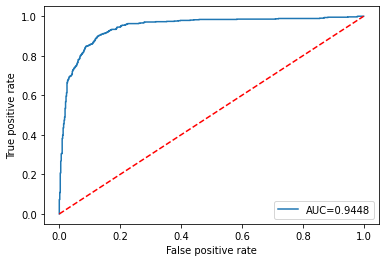

NN test set performance:	AUC=0.9448	Accuracy=0.8808
Confusion matrix:
[[558  74]
 [ 75 543]]


In [62]:
# assess sentiment classification model
assess_sentiment_classifier(y_test, predictions)

That's a much better result than we were able to achieve with the pipeline or any other deep neural network before.

## A note on transfer learning

Transfer learning is the technique of training a model to do one task and then use it to do another. In our case we used the pipeline model, that was pretrained on natural text and used it to predict sentiments on highly preprocessed movie reviews. Let's see how the pipeline performs on the raw movie review data.

In [63]:
# perform train-test split with raw data
X_train, X_test, y_train, y_test = IMDB_train_test_split(df, preprocessed=False)

In [64]:
# generate predictions
predictions = pipeline_classify(X_test)

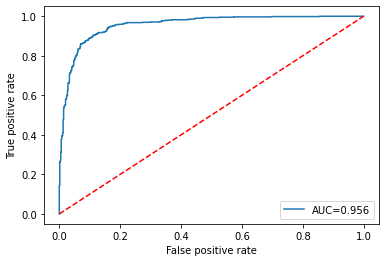

NN test set performance:	AUC=0.9560	Accuracy=0.8928
Confusion matrix:
[[580  52]
 [ 82 536]]


In [ ]:
# evaluate the results
assess_sentiment_classifier(y_test, predictions)

As opposed to our previous models, the performance of the pipeline is much better on the raw data. Since the model is trained on natural text and has a much higher level of complexity than our previous neural network architectures it is able to extract information well from coherent sentences. In this case removing stop words and punctuation therefore constituted a loss of information.

If you like, you can also go ahead and finetune the DistilBert model on the raw data as an exercise and see how much of an improvement you're going to get there.